In [ ]:
import boto3
import io

In [3]:
# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load data into a PySpark DataFrame
df = spark.read.csv("s3://finalprojectbigdata/inputfiles/Churn_Modelling.csv", header=True, inferSchema=True)
#df = spark.read.csv("/content/Churn_Modelling.csv", header=True, inferSchema=True)



In [4]:
# Data Exploration
from pyspark.sql.functions import col,when
df.show(5)
df.printSchema()
df.columns
#df.info()
#df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_values = df.select([col(c).isNull().alias(c) for c in df.columns]).toPandas().sum().to_frame().rename(columns={0: "Total No. of Missing Values"})
print(missing_values)
#df[df.duplicated()]
# Assuming 'df' is your PySpark DataFrame
df_no_duplicates = df.dropDuplicates()

# Check the shape of the DataFrame after removing duplicates
print("Shape after removing duplicates:", (df_no_duplicates.count(), len(df_no_duplicates.columns)))

#df.describe(include="object").T
df.summary().show()

# Assuming 'df' is your PySpark DataFrame
df.limit(5)  # Replace 5 with the desired number of rows
# Assuming 'df' is your PySpark DataFrame
columns_to_drop = ["RowNumber", "CustomerId", "Surname"]
df = df.drop(*columns_to_drop)

# Renaming the "Exited" column to "Churned"
df = df.withColumnRenamed("Exited", "Churned")

# Converting "Churned" values to "No" and "Yes"
df = df.withColumn("Churned", when(df["Churned"] == 0, "No").otherwise("Yes"))

df.head()


+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

Row(CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, HasCrCard=1, IsActiveMember=1, EstimatedSalary=101348.88, Churned='Yes')

In [5]:
# Assuming 'df' is your PySpark DataFrame
count = df.groupBy("Churned").count()
count.show()


+-------+-----+
|Churned|count|
+-------+-----+
|     No| 7963|
|    Yes| 2037|
+-------+-----+



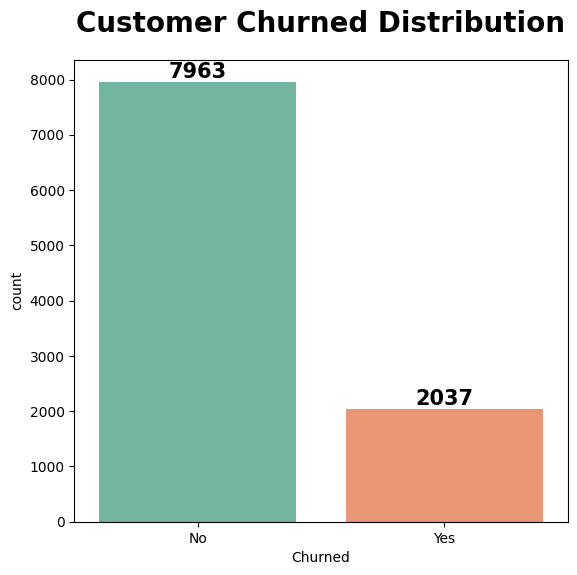

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
df_pd = df.toPandas()
df_pd["Churned"] = df_pd["Churned"].astype("category")
plt.figure(figsize=(14, 6))

# Plot countplot
plt.subplot(1, 2, 1)
ax = sns.countplot(x="Churned", data=df_pd, palette="Set2")
ax.bar_label(ax.containers[0], fontweight="black", size=15)
plt.title("Customer Churned Distribution", fontweight="black", size=20, pad=20)


plt.show()
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/customer_Churned_Distribution.png', Body=buf)


In [7]:
def countplot(column):
    plt.figure(figsize=(15,5))
    ax = sns.countplot(x=column, data=df_pd, hue="Churned",palette="Set2")
    for value in ax.patches:
        # Filter and count data using PySpark functions
        filtered_data = df.filter(col(column) == value.get_label()) \
            .groupBy("Churned") \
            .count() \
            .toPandas()

        # Check if the DataFrame is not empty
        if not filtered_data.empty:
            percentage = "{:.1f}%".format(100 * filtered_data["count"].values[0] / len(df_pd))
            x = value.get_x() + value.get_width() / 2 - 0.05
            y = value.get_y() + value.get_height()
            ax.annotate(percentage, (x, y), fontweight="black", size=15)

    plt.title(f"Customer Churned by {column}", fontweight="black", size=20, pad=20)
    plt.show()



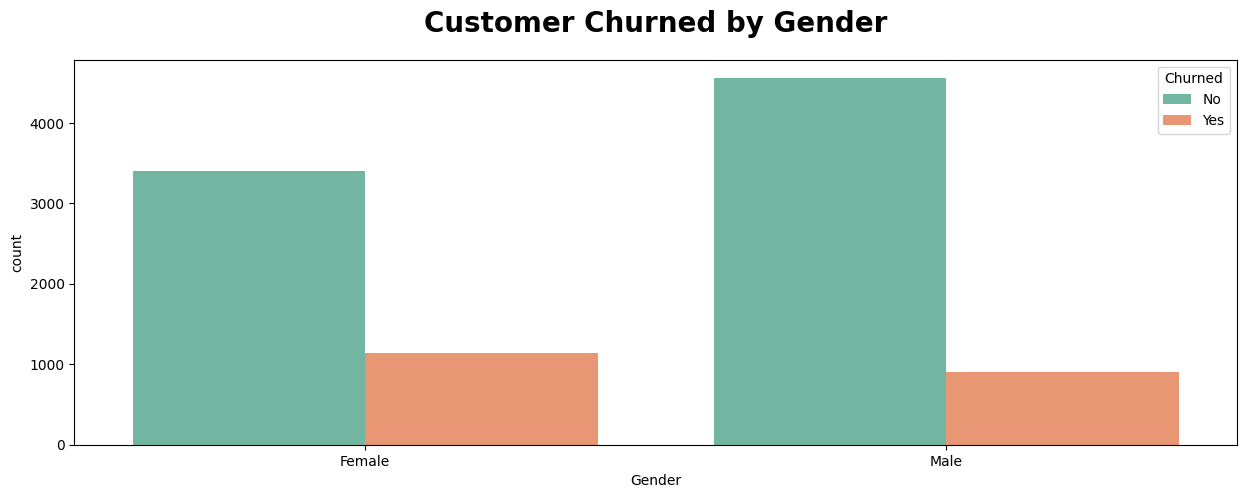

In [8]:
countplot("Gender")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_gender.png', Body=buf)

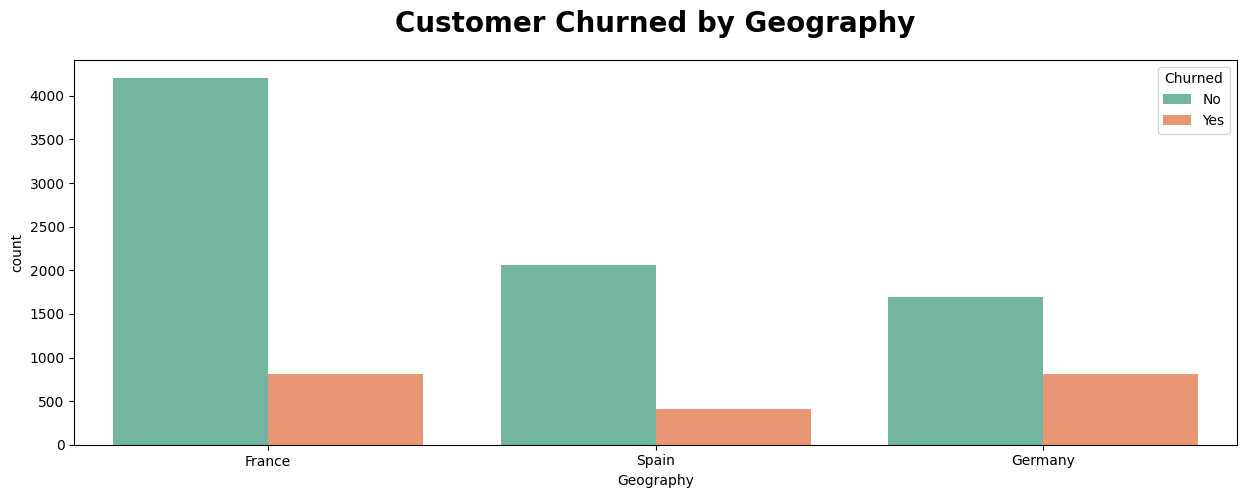

In [9]:
countplot("Geography")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_geography.png', Body=buf)

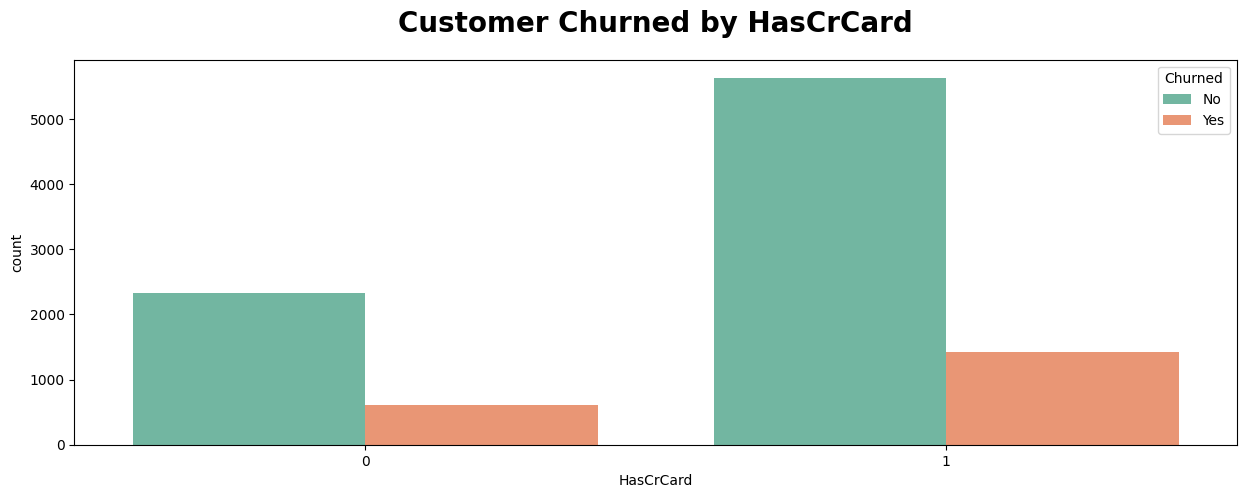

In [10]:
countplot("HasCrCard")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_hascrcard.png', Body=buf)

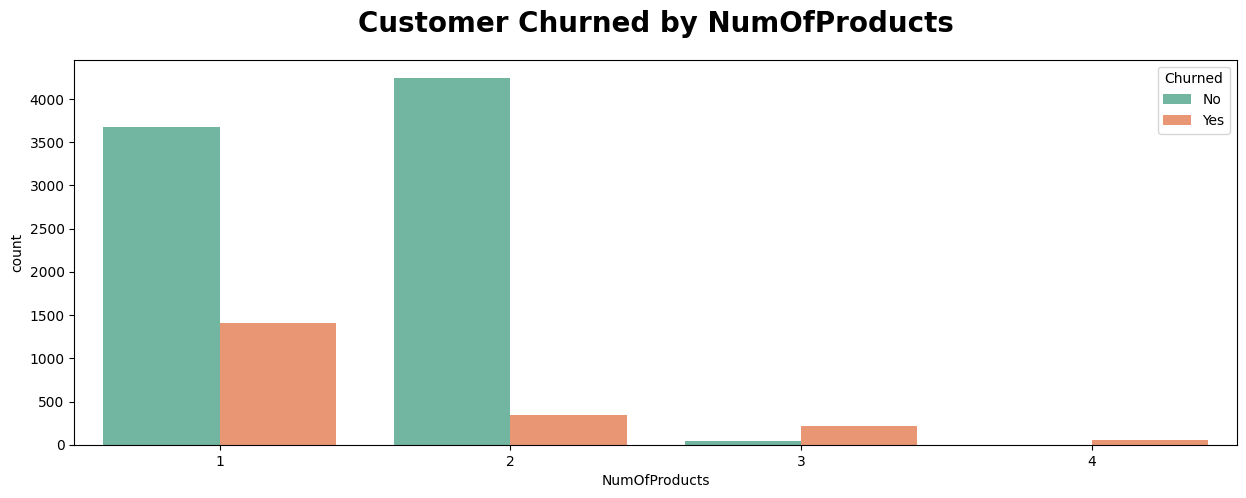

In [11]:
countplot("NumOfProducts")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_numofproducts.png', Body=buf)


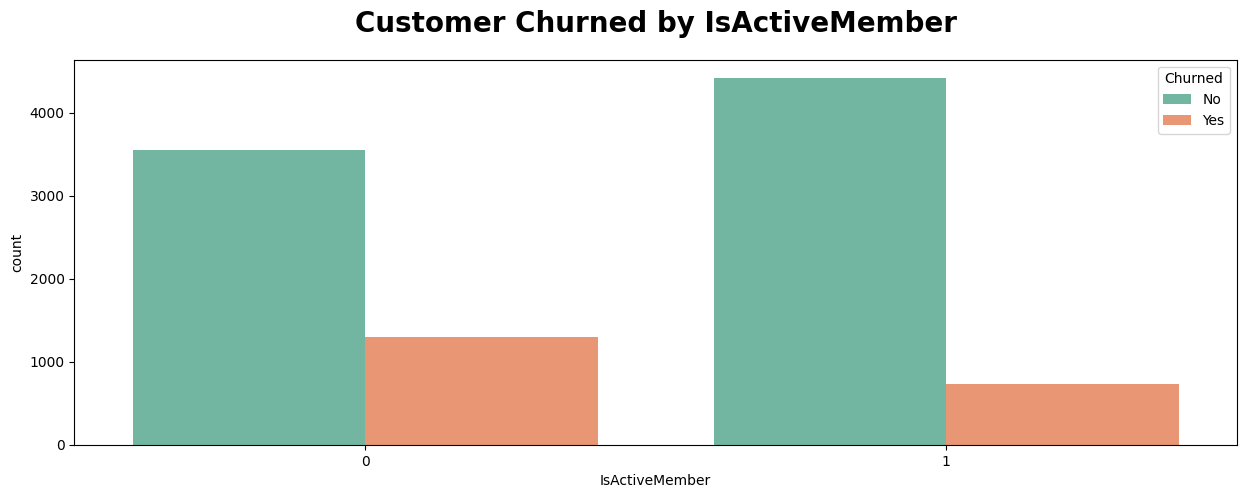

In [12]:
countplot("IsActiveMember")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_isactivemember.png', Body=buf)

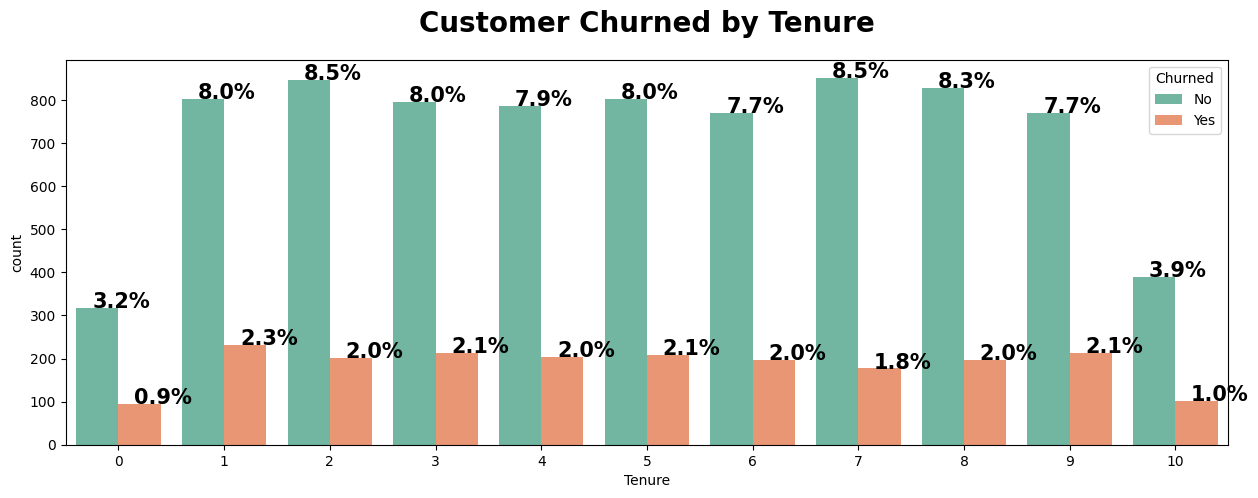

In [13]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x="Tenure", data=df_pd, hue="Churned", palette="Set2")

for value in ax.patches:
    # Convert PySpark DataFrame column to Pandas Series for length calculation
    tenure_series = df.select("Tenure").toPandas()["Tenure"]

    percentage = "{:.1f}%".format(100 * value.get_height() / len(tenure_series))
    x = value.get_x() + value.get_width() / 2 - 0.05
    y = value.get_y() + value.get_height()
    ax.annotate(percentage, (x, y), fontweight="black", size=15)

plt.title("Customer Churned by Tenure", fontweight="black", size=20, pad=20)
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_tenure.png', Body=buf)

In [14]:
def continous_plot(column):
    # Convert PySpark DataFrame to Pandas DataFrame
    df_pd = df.toPandas()

    plt.figure(figsize=(13, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(x=column, hue="Churned", data=df_pd, kde=True, palette="Set2")
    plt.title(f"Distribution of {column} by Churn Status", fontweight="black", pad=20, size=15)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x="Churned", y=column, data=df_pd, palette="Set2")
    plt.title(f"Distribution of {column} by Churn Status", fontweight="black", pad=20, size=15)

    plt.tight_layout()
    plt.show()



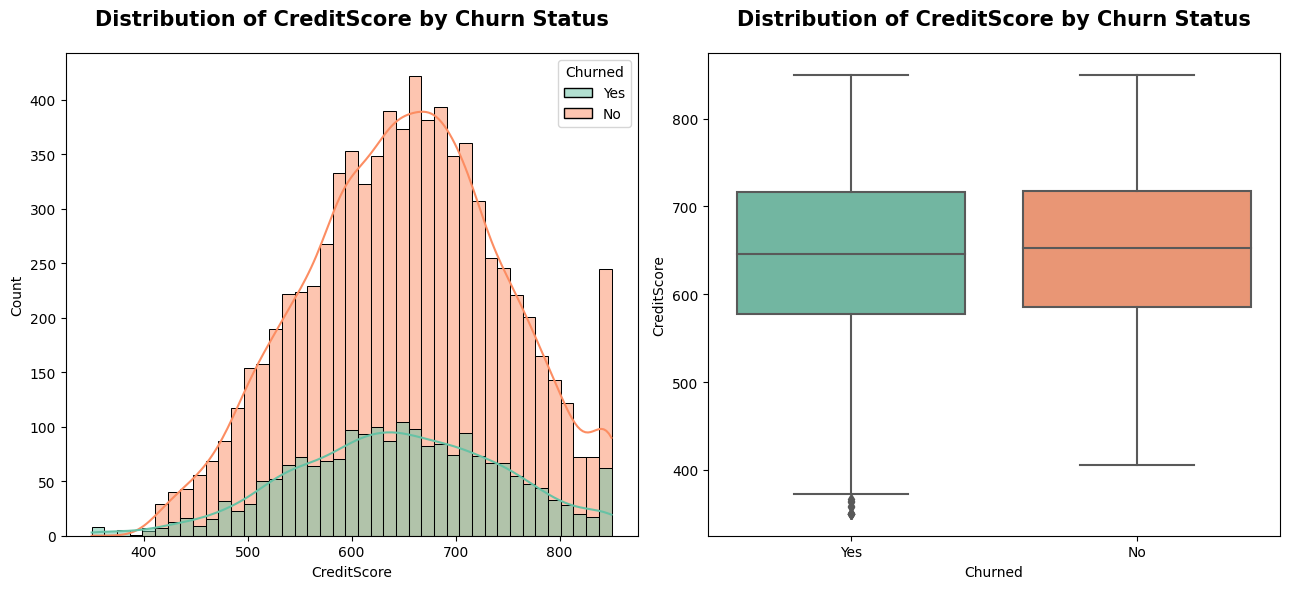

In [15]:
continous_plot("CreditScore")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_creditScore.png', Body=buf)


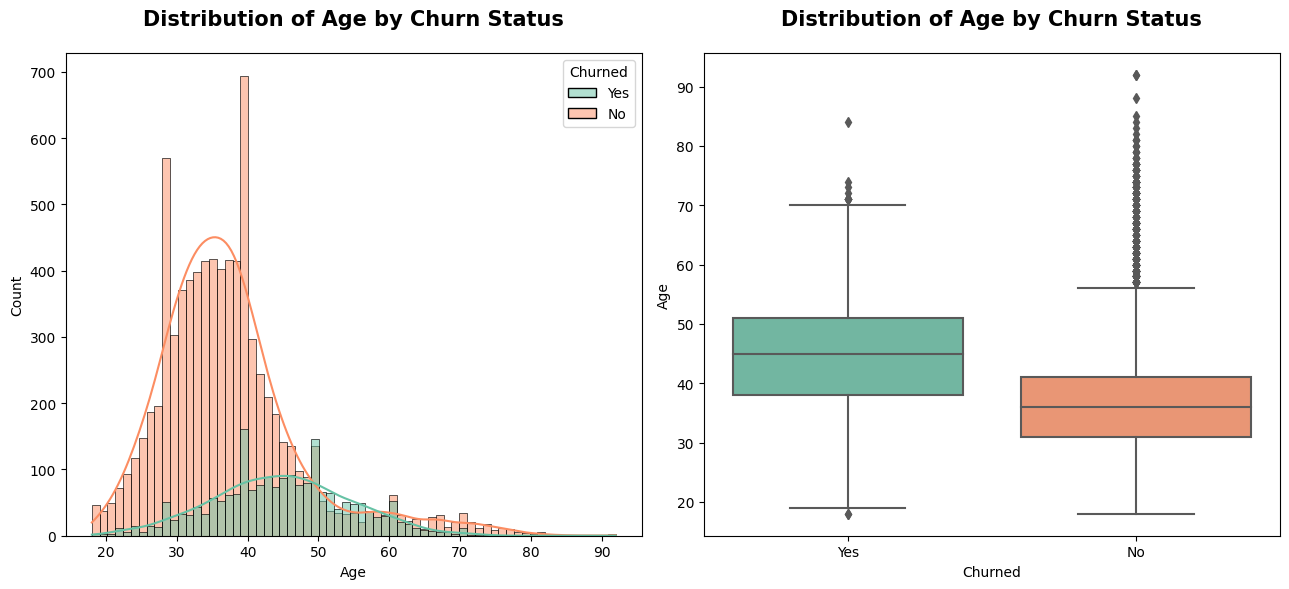

In [16]:
continous_plot("Age")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_age.png', Body=buf)


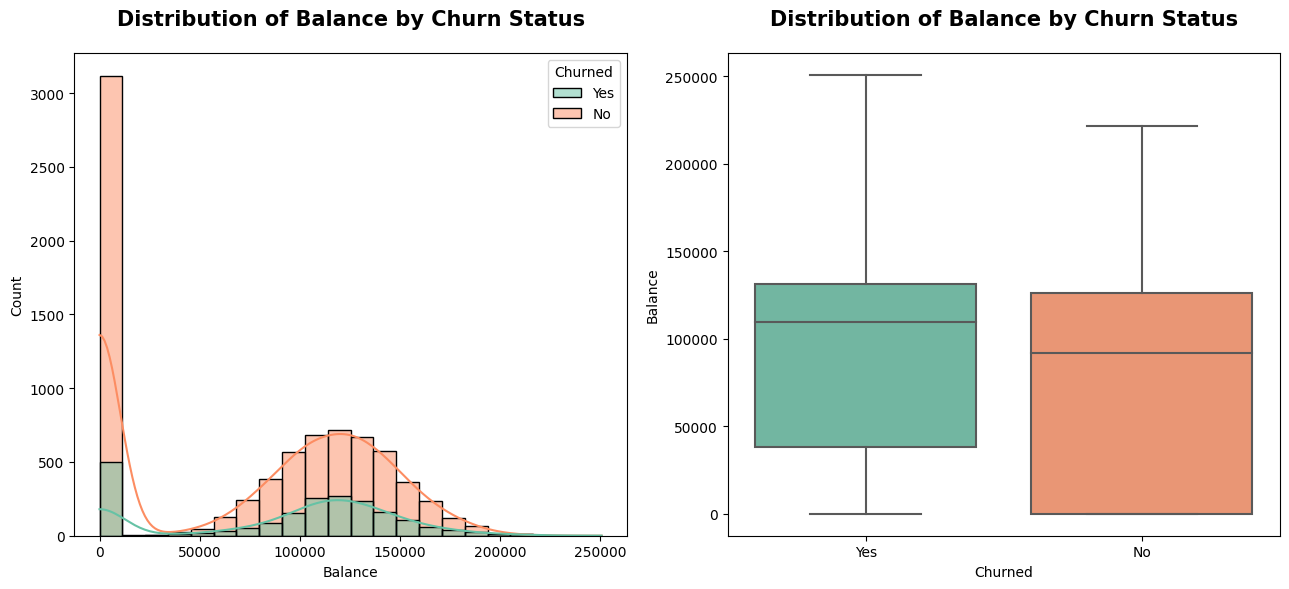

In [17]:
continous_plot("Balance")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_balance.png', Body=buf)

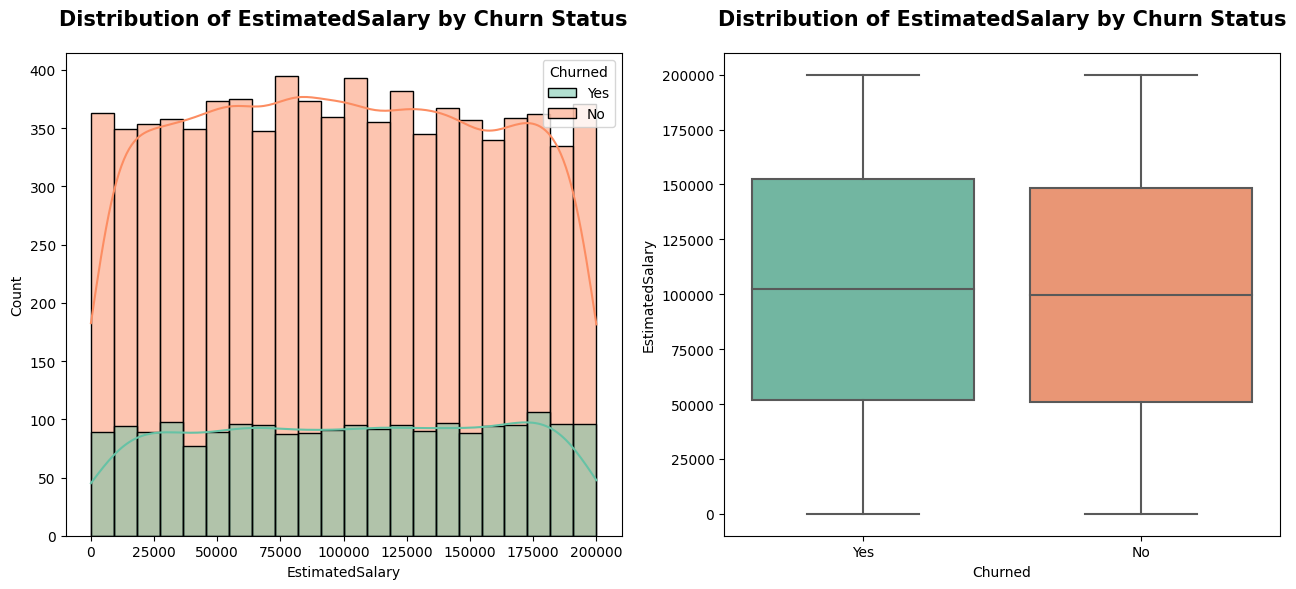

In [18]:
continous_plot("EstimatedSalary")
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_EstimatedSalary.png', Body=buf)

In [19]:
conditions = [(df["NumOfProducts"]==1), (df["NumOfProducts"]==2), (df["NumOfProducts"]>2)]
values =     ["One product","Two Products","More Than 2 Products"]

In [20]:
import numpy as np

# Define conditions and values for the NumOfProducts column
conditions = [
    (df["NumOfProducts"] == 1),
    (df["NumOfProducts"] == 2),
    (df["NumOfProducts"] > 2)
]

values = ["One product", "Two Products", "More Than 2 Products"]

# Use np.select to create a new column "Total_Products"
df = df.withColumn("Total_Products", F.when(conditions[0], values[0])
                                    .when(conditions[1], values[1])
                                    .when(conditions[2], values[2])
                                    .otherwise("Other"))

# Drop the original NumOfProducts column
df = df.drop("NumOfProducts")

# Show the resulting DataFrame
df.show(5)


+-----------+---------+------+---+------+---------+---------+--------------+---------------+-------+--------------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|
+-----------+---------+------+---+------+---------+---------+--------------+---------------+-------+--------------------+
|        619|   France|Female| 42|     2|      0.0|        1|             1|      101348.88|    Yes|         One product|
|        608|    Spain|Female| 41|     1| 83807.86|        0|             1|      112542.58|     No|         One product|
|        502|   France|Female| 42|     8| 159660.8|        1|             0|      113931.57|    Yes|More Than 2 Products|
|        699|   France|Female| 39|     1|      0.0|        0|             0|       93826.63|     No|        Two Products|
|        850|    Spain|Female| 43|     2|125510.82|        1|             1|        79084.1|     No|         One product|
+-----------+---------+-

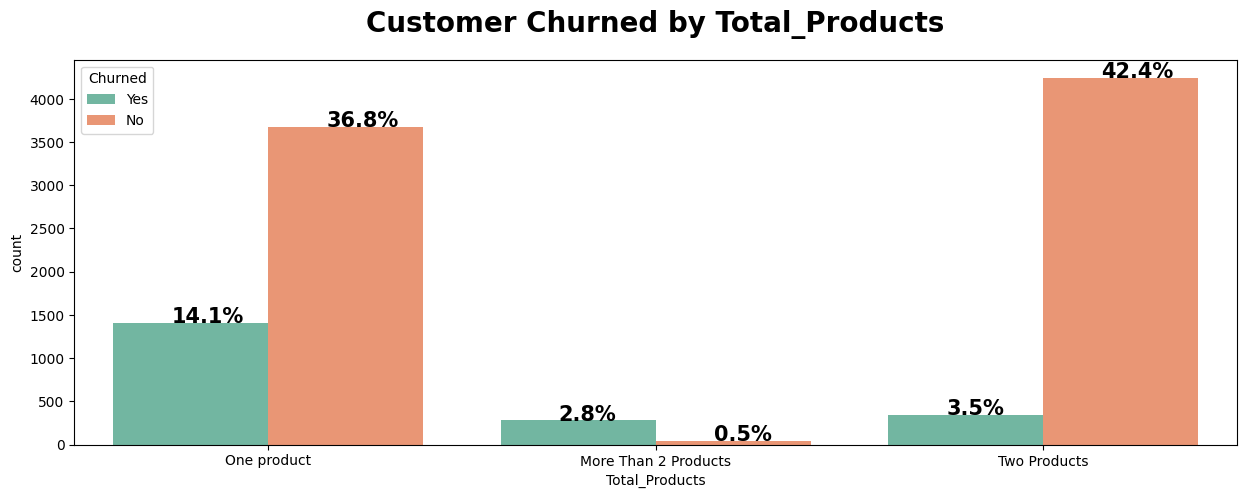

In [21]:
def countplot(column, df):
    plt.figure(figsize=(15, 5))
    ax = sns.countplot(x=column, data=df.toPandas(), hue="Churned", palette="Set2")
    for value in ax.patches:
        percentage = "{:.1f}%".format(100 * value.get_height() / df.count())
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x, y), fontweight="black", size=15)

    plt.title(f"Customer Churned by {column}", fontweight="black", size=20, pad=20)
    plt.show()

# Example usage:
countplot("Total_Products", df)
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_total_products.png', Body=buf)


In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Assuming df is your PySpark DataFrame
# Define conditions and values for the Balance column
conditions = [
    (F.col("Balance") == 0),
    (F.col("Balance") > 0)
]

values = ["Zero Balance", "More Than zero Balance"]

# Use np.select to create a new column "Account_Balance"
df = df.withColumn("Account_Balance", F.when(conditions[0], values[0])
                                     .when(conditions[1], values[1])
                                     .otherwise("Other"))

# Drop the original Balance column
df = df.drop("Balance")

# Show the resulting DataFrame
df.show(5)


+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+
|CreditScore|Geography|Gender|Age|Tenure|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|     Account_Balance|
+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+
|        619|   France|Female| 42|     2|        1|             1|      101348.88|    Yes|         One product|        Zero Balance|
|        608|    Spain|Female| 41|     1|        0|             1|      112542.58|     No|         One product|More Than zero Ba...|
|        502|   France|Female| 42|     8|        1|             0|      113931.57|    Yes|More Than 2 Products|More Than zero Ba...|
|        699|   France|Female| 39|     1|        0|             0|       93826.63|     No|        Two Products|        Zero Balance|
|        850|    Spain|Female| 43|     2|        1|             1|   

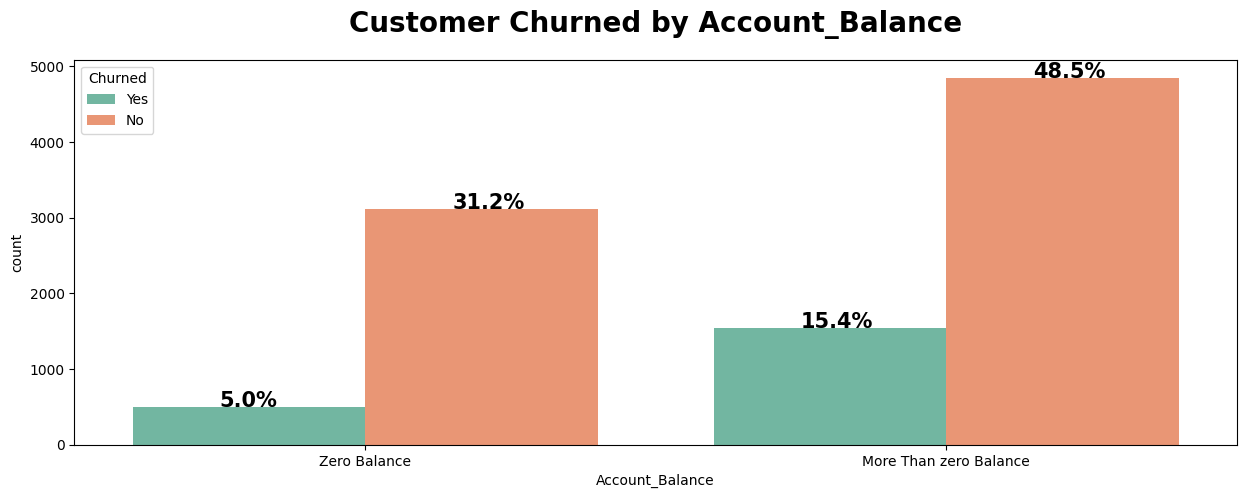

In [23]:
countplot("Account_Balance",df)
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_accountbalanace.png', Body=buf)

In [24]:
from pyspark.sql import SparkSession

# Assuming df is your PySpark DataFrame

# List of categorical columns
cat_cols = ["Gender", "Geography","Total_Products", "Account_Balance"]

# Iterate through categorical columns
for column in cat_cols:
    print(f"Unique Values in {column} column is:")
    df.select(column).distinct().show()
    print("-" * 100, "\n")


Unique Values in Gender column is:
+------+
|Gender|
+------+
|Female|
|  Male|
+------+

---------------------------------------------------------------------------------------------------- 

Unique Values in Geography column is:
+---------+
|Geography|
+---------+
|  Germany|
|   France|
|    Spain|
+---------+

---------------------------------------------------------------------------------------------------- 

Unique Values in Total_Products column is:
+--------------------+
|      Total_Products|
+--------------------+
|More Than 2 Products|
|         One product|
|        Two Products|
+--------------------+

---------------------------------------------------------------------------------------------------- 

Unique Values in Account_Balance column is:
+--------------------+
|     Account_Balance|
+--------------------+
|        Zero Balance|
|More Than zero Ba...|
+--------------------+

------------------------------------------------------------------------------------------

In [25]:
df.show(5)

+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+
|CreditScore|Geography|Gender|Age|Tenure|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|     Account_Balance|
+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+
|        619|   France|Female| 42|     2|        1|             1|      101348.88|    Yes|         One product|        Zero Balance|
|        608|    Spain|Female| 41|     1|        0|             1|      112542.58|     No|         One product|More Than zero Ba...|
|        502|   France|Female| 42|     8|        1|             0|      113931.57|    Yes|More Than 2 Products|More Than zero Ba...|
|        699|   France|Female| 39|     1|        0|             0|       93826.63|     No|        Two Products|        Zero Balance|
|        850|    Spain|Female| 43|     2|        1|             1|   

In [26]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# List of categorical columns to be one-hot encoded
cat_cols = ["Gender", "Geography", "Total_Products", "Account_Balance"]

# Create a list to store the stages of the pipeline
stages = []

# Apply StringIndexer and OneHotEncoder for each categorical column
for cat_col in cat_cols:
    # StringIndexer
    indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_index")

    # OneHotEncoder
    encoder = OneHotEncoder(inputCol=f"{cat_col}_index", outputCol=f"{cat_col}_encoded")

    # Add stages to the pipeline
    stages += [indexer, encoder]

# Add other stages of the pipeline (if any)
# ...

# Combine all stages into a pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline on your DataFrame
df_transformed = pipeline.fit(df).transform(df)

# Select relevant columns (original and encoded) from the transformed DataFrame
selected_cols = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churned', 'Total_Products', 'Account_Balance', 'Gender_index', 'Gender_encoded', 'Geography_index', 'Geography_encoded', 'Total_Products_index', 'Total_Products_encoded', 'Account_Balance_index', 'Account_Balance_encoded']
selected_cols += [f"{column}_encoded" for column in cat_cols]

# Show the resulting DataFrame
df = df_transformed.select(*selected_cols)
df.show(5)


+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------------------+---------------------+-----------------------+--------------+-----------------+----------------------+-----------------------+
|CreditScore|Geography|Gender|Age|Tenure|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|     Account_Balance|Gender_index|Gender_encoded|Geography_index|Geography_encoded|Total_Products_index|Total_Products_encoded|Account_Balance_index|Account_Balance_encoded|Gender_encoded|Geography_encoded|Total_Products_encoded|Account_Balance_encoded|
+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------------------+---------------------+----------

In [27]:

# Assuming 'Churned' is a string column
df = df.withColumn("Churned", when(df["Churned"] == "No", 0).otherwise(1))


In [28]:
df.show(5)

+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------------------+---------------------+-----------------------+--------------+-----------------+----------------------+-----------------------+
|CreditScore|Geography|Gender|Age|Tenure|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|     Account_Balance|Gender_index|Gender_encoded|Geography_index|Geography_encoded|Total_Products_index|Total_Products_encoded|Account_Balance_index|Account_Balance_encoded|Gender_encoded|Geography_encoded|Total_Products_encoded|Account_Balance_encoded|
+-----------+---------+------+---+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------------------+---------------------+----------

In [29]:
cols = ["CreditScore","Age","EstimatedSalary"]

In [30]:
from pyspark.sql.functions import skewness

# Assuming cols is a list of column names
skewness_values = df.agg(*(skewness(col).alias(col) for col in cols))

# Display the skewness values
skewness_values.show()


+--------------------+------------------+--------------------+
|         CreditScore|               Age|     EstimatedSalary|
+--------------------+------------------+--------------------+
|-0.07159586676212142|1.0111685586628147|0.002085044844874...|
+--------------------+------------------+--------------------+



In [31]:
old_age = df["Age"]     ##Storing the previous Age values to compare these values with the transformed values.


In [32]:
from pyspark.sql.functions import col, log

# Assuming df is your DataFrame
df = df.withColumn("Age", log(col("Age")))


Text(0.5, 1.0, 'Age Distribution after Transformation')

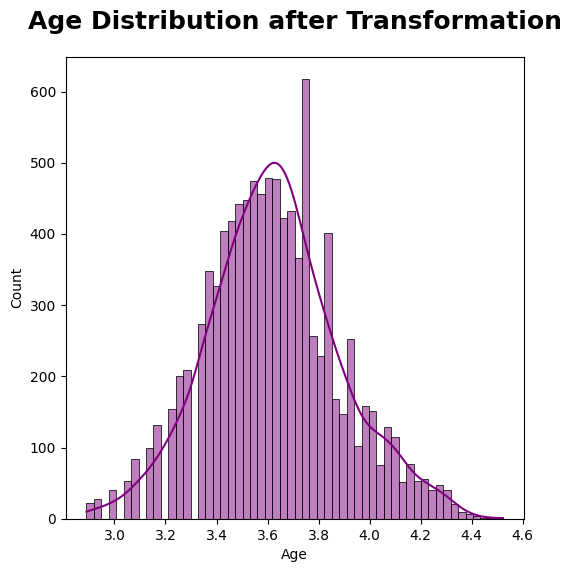

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming old_age is a PySpark DataFrame column
# Convert it to a Pandas DataFrame or Series
old_age_values = df.select("Age").toPandas()["Age"]

plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
sns.histplot(old_age_values, color="purple", kde=True)
plt.title("Age Distribution after Transformation", fontweight="black", size=18, pad=20)
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_Age _Distribution_after_Transformation.png', Body=buf)

In [34]:
# Assuming df is your PySpark DataFrame
X = df.select([col for col in df.columns if col not in columns_to_drop])
y = df.select("Churned")

# Show the updated X and y DataFrames
X.show(5)
y.show(5)


+-----------+---------+------+------------------+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------------------+---------------------+-----------------------+--------------+-----------------+----------------------+-----------------------+
|CreditScore|Geography|Gender|               Age|Tenure|HasCrCard|IsActiveMember|EstimatedSalary|Churned|      Total_Products|     Account_Balance|Gender_index|Gender_encoded|Geography_index|Geography_encoded|Total_Products_index|Total_Products_encoded|Account_Balance_index|Account_Balance_encoded|Gender_encoded|Geography_encoded|Total_Products_encoded|Account_Balance_encoded|
+-----------+---------+------+------------------+------+---------+--------------+---------------+-------+--------------------+--------------------+------------+--------------+---------------+-----------------+--------------------+----------

In [35]:
# Convert target variable to numerical using StringIndexer
indexer = StringIndexer(inputCol="Churned", outputCol="label")
df = indexer.fit(df).transform(df)

In [36]:
# Train-test split
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=0)

In [37]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Assuming df is your DataFrame
# Assuming "Churned" is your target variable
minority_class = df.filter(col("Churned") == 1)
majority_class = df.filter(col("Churned") == 0)

# Oversample the minority class
minority_class_oversampled = minority_class.sample(withReplacement=True, fraction=2.0, seed=42)

# Combine oversampled minority class with majority class
oversampled_df = majority_class.unionAll(minority_class_oversampled)

# Now, oversampled_df contains the oversampled dataset


In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

# Assuming df is your DataFrame and you have already encoded categorical variables
# Features you want to use for training
feature_cols = ["CreditScore", "Age", "Tenure", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Gender_encoded", "Geography_encoded", "Total_Products_encoded", "Account_Balance_encoded"]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create a Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=0)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Fit the pipeline on the training data
dt_model = pipeline.fit(train_data)


In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test set
predictions_dt = dt_model.transform(test_data)

# Evaluate accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)

print("Accuracy for Decision Tree: {:.2%}".format(accuracy_dt))


Accuracy for Decision Tree: 85.69%


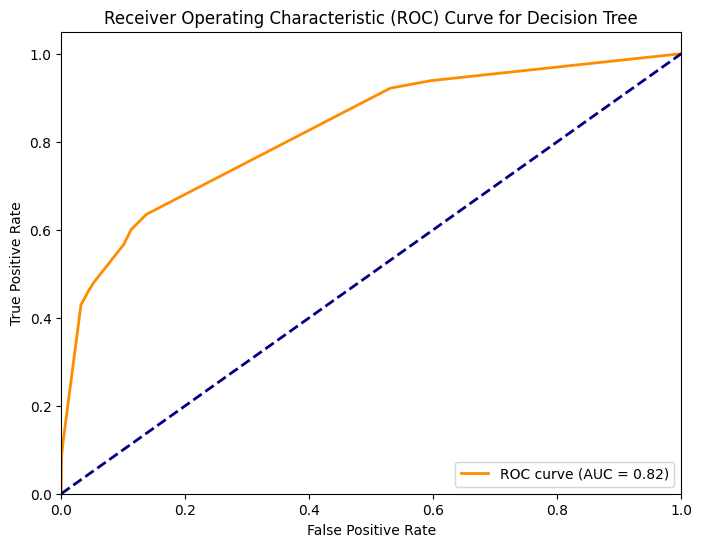

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'predictions_dt' is your DataFrame containing 'label' and 'probability' columns
y_true_dt = predictions_dt.select("label").rdd.map(lambda row: float(row.label))
y_prob_dt = predictions_dt.select("probability").rdd.map(lambda row: float(row.probability[1]))

# Calculate the ROC curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_true_dt.collect(), y_prob_dt.collect())

# Calculate the area under the ROC curve
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_dt))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_ROCForDecessionTree.png', Body=buf)

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator



# For Binary Classification
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
area_under_curve = binary_evaluator.evaluate(predictions_dt)

# For Multiclass Classification
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Precision
precision = multi_evaluator.evaluate(predictions_dt, {multi_evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")

# Recall
recall = multi_evaluator.evaluate(predictions_dt, {multi_evaluator.metricName: "weightedRecall"})
print(f"Recall: {recall}")

# F1-Score
f1_score = multi_evaluator.evaluate(predictions_dt, {multi_evaluator.metricName: "f1"})
print(f"F1-Score: {f1_score}")


Precision: 0.8457091394485656
Recall: 0.85693359375
F1-Score: 0.8447225035204557


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


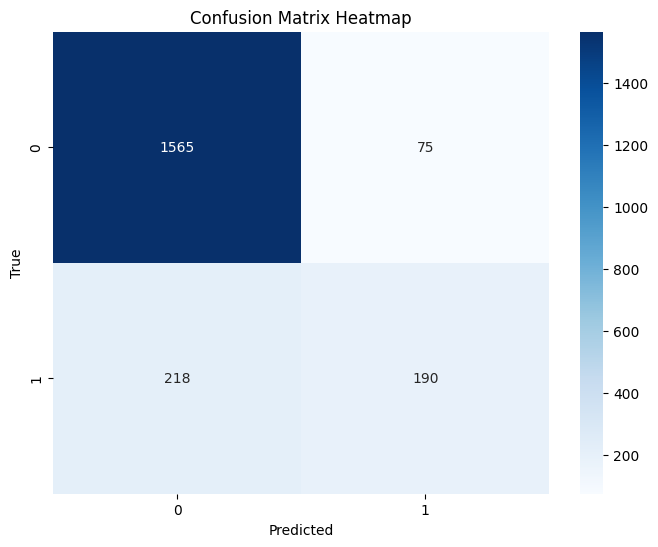

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics

# Assuming 'predictions_rf' is your DataFrame containing 'label' and 'prediction' columns
prediction_and_label = predictions_dt.select("prediction", "label").rdd

# Instantiate a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Define classes (if not already defined)
classes = [str(i) for i in range(confusion_matrix.shape[0])]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_confusionmatrixDecessionTree.png', Body=buf)

In [43]:
feature_cols = ["CreditScore", "Age", "Tenure", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Gender_encoded", "Geography_encoded", "Total_Products_encoded", "Account_Balance_encoded"]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create a Random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=0)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the pipeline on the training data
rf_model = pipeline.fit(train_data)

In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test set
predictions_rf = rf_model.transform(test_data)

# Evaluate accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions_rf)

print("Accuracy for Random forest: {:.2%}".format(accuracy_rf))


Accuracy for Random forest: 85.69%


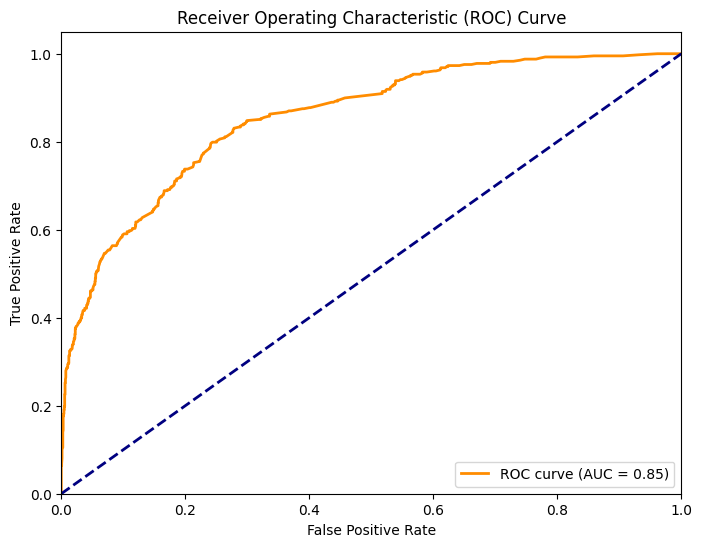

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'predictions_rf' is your DataFrame containing 'label' and 'probability' columns
y_true = predictions_rf.select("label").rdd.map(lambda row: float(row.label))
y_prob = predictions_rf.select("probability").rdd.map(lambda row: float(row.probability[1]))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true.collect(), y_prob.collect())

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_ROCFORrandomForest.png', Body=buf)

In [46]:
# For Binary Classification
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
area_under_curve = binary_evaluator.evaluate(predictions_rf)

# For Multiclass Classification
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Precision
precision = multi_evaluator.evaluate(predictions_rf, {multi_evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")

# Recall
recall = multi_evaluator.evaluate(predictions_rf, {multi_evaluator.metricName: "weightedRecall"})
print(f"Recall: {recall}")

# F1-Score
f1_score = multi_evaluator.evaluate(predictions_rf, {multi_evaluator.metricName: "f1"})
print(f"F1-Score: {f1_score}")

Precision: 0.8497996686765743
Recall: 0.85693359375
F1-Score: 0.8360276767999395


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


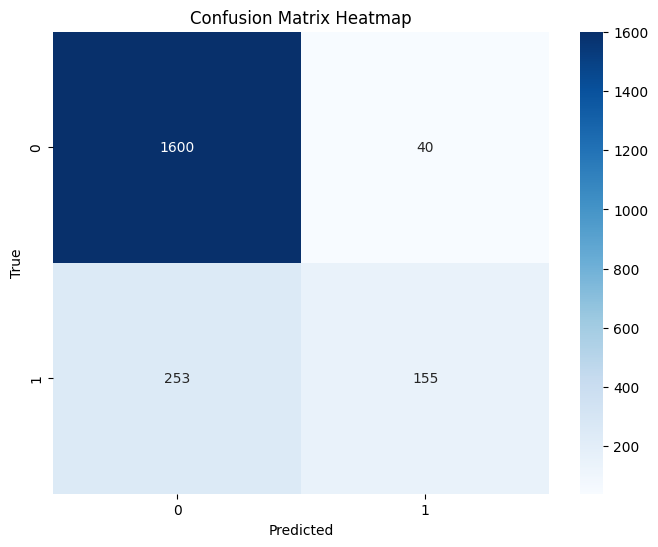

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics

# Assuming 'predictions_rf' is your DataFrame containing 'label' and 'prediction' columns
prediction_and_label = predictions_rf.select("prediction", "label").rdd

# Instantiate a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Define classes (if not already defined)
classes = [str(i) for i in range(confusion_matrix.shape[0])]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
s3 = boto3.client('s3')
s3.put_object(Bucket='finalprojectbigdata', Key='outputfiles/Customer_Churned_by_heatmapforrandomforest.png', Body=buf)


In [48]:
#df.write.mode("overwrite").parquet("s3://finalprojectbigdata/outputfiles/")

In [ ]:

# Close the buffer
buf.close()

In [ ]:
# Close the Spark session
spark.stop()
